# **DSIM - E02 Assignment: Classification based on 2D Features**

Implementation of three feature extractors based on **Spectrogram**, **Mel Spectrogram**, and **MFCC** for audio classification on the Free Spoken Digit Dataset.

**Approach:**
1. Extract the 2-dimensional feature
2. Force the feature to have fixed size
3. Unroll the 2-dimensional feature into a 1-dimensional vector

**Key insight:** we fix the temporal size *before* flattening. Flattening first and then truncating/padding would misalign frequency information across signals of different lengths, making features meaningless for the classifier.

In [ ]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from google.colab import drive
import tarfile
from shutil import copyfile

from scipy.fft import rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow
import librosa

In [ ]:
drive.mount('/content/gdrive')
copyfile('/content/gdrive/MyDrive/Second year/First semester/Digital signals and image management/DSIM Lab/DSIM_E02_notebook/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/tmp/ipython-input-3997466839.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


In [ ]:
def identity(input):
    return input

def load_data(feature_extractor=identity, normalize=False):
    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)
            label = f.split('_')[0]
            labels.append(label)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]
        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

## Feature extraction strategy

All three features (Spectrogram, Mel Spectrogram, MFCC) produce **2D matrices** of shape $(F, T)$, where:
- $F$ = number of frequency bins (rows), fixed by the extraction parameters
- $T$ = number of time frames (columns), **variable** depending on audio duration

To feed them into an SVM classifier we need to:
1. **Fix the temporal dimension** to a constant `tsize`: truncate if $T > \text{tsize}$, zero-pad if $T < \text{tsize}$
2. **Flatten** the 2D matrix into a 1D vector via `ravel()` (row-major order)

Additionally, converting amplitudes/power to **decibel scale** compresses the dynamic range and generally improves classification performance.

Since we load audio with `scipy.io.wavfile` (native sample rate = 8000 Hz), the `rate` parameter in our functions is consistent with the actual signal.

## 1. Spectrogram features

The spectrogram is computed via the Short-Time Fourier Transform (STFT). The signal is divided into overlapping windows, and the FFT is applied to each window:

$$
S(f,t)=\bigl|\sum_{n} x[n]\;w[n-t]\;e^{-j2\pi f n}\bigr|^{2}
$$


We use `scipy.signal.spectrogram` with default parameters (`nperseg=256`), yielding $F = \lfloor 256/2 \rfloor + 1 = 129$ frequency bins.

The power spectrogram is then converted to **decibel scale** for better numeric stability:

$$S_{dB}(f,t) = 10 \cdot \log_{10}\left(\frac{S(f,t)}{S_{ref}}\right)$$

where $S_{ref} = \max(S)$.

In [ ]:
def feats_spectrogram(input, rate=8000, tsize=10):
    _, _, spec = spectrogram(input, fs=rate)

    spec_db = librosa.power_to_db(spec, ref=np.max)

    if spec_db.shape[1] >= tsize:
        spec_db = spec_db[:, :tsize]
    else:
        pad_width = tsize - spec_db.shape[1]
        spec_db = np.pad(spec_db, ((0, 0), (0, pad_width)), mode='constant')

    return spec_db.ravel()

Feature shape: (1290,)
Training completed in 41.612s

Best parameters:
 C: 100
 gamma: 0.005

Classification report (Spectrogram):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.83      1.00      0.91        10
           2       1.00      1.00      1.00        15
           3       0.90      0.95      0.92        19
           4       1.00      1.00      1.00        11
           5       1.00      0.86      0.92        14
           6       0.70      1.00      0.82        14
           7       0.89      0.89      0.89        19
           8       1.00      0.82      0.90        17
           9       1.00      0.71      0.83        14

    accuracy                           0.92       150
   macro avg       0.93      0.92      0.92       150
weighted avg       0.93      0.92      0.92       150



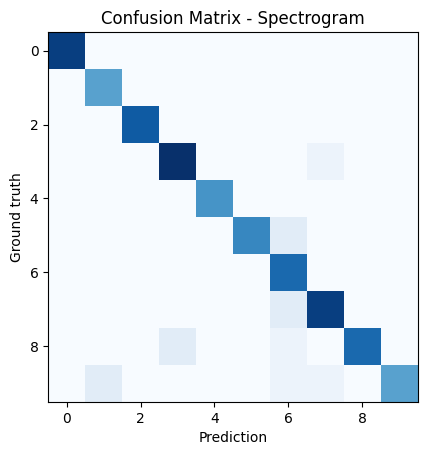

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_spectrogram, normalize=True)
print('Feature shape:', X_train[0].shape)

param_grid = {'C': [100, 500, 1000],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

print('\nBest parameters:')
print(' C: ' + str(clf.best_estimator_.C))
print(' gamma: ' + str(clf.best_estimator_.gamma))

y_pred = clf.predict(X_test)
print('\nClassification report (Spectrogram):')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.title('Confusion Matrix - Spectrogram')
plt.show()

**Observation:** the spectrogram achieves **92% accuracy** — a dramatic improvement over the best scalar features from E01 (67% with 7 features). The 2D time-frequency representation captures the full spectral evolution of each digit, providing far richer information than scalar statistics. All 10 classes are well-classified, with class 6 having the lowest precision (70%) due to some confusion with other digits. The dB conversion is important: it compresses the dynamic range (raw power values can span several orders of magnitude), making the features more suitable for the RBF kernel of the SVM.

## 2. Mel Spectrogram features

The Mel spectrogram redistributes the linear frequency axis onto the **Mel scale**, which approximates human auditory perception. Lower frequencies get finer resolution, higher frequencies are grouped more coarsely.

The Hertz-to-Mel conversion is:

$$m = 2595 \cdot \log_{10}\left(1 + \frac{f}{700}\right)$$

A bank of $N_{mel}$ triangular filters is applied to the power spectrogram, producing a matrix of shape $(N_{mel}, T)$. We use `librosa.feature.melspectrogram` with `n_fft=512` (to avoid warnings on short signals) and default $N_{mel} = 128$.

The output is converted to **decibel scale** via `librosa.power_to_db`.

In [ ]:
def feats_mel(input, rate=8000, tsize=10):
    mel = melspectrogram(y=input * 1.0, sr=rate, n_fft=512)

    mel_db = librosa.power_to_db(mel, ref=np.max)

    if mel_db.shape[1] >= tsize:
        mel_db = mel_db[:, :tsize]
    else:
        pad_width = tsize - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')

    return mel_db.ravel()

Feature shape: (1280,)
Training completed in 35.739s

Best parameters:
 C: 100
 gamma: 0.005

Classification report (Mel Spectrogram):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.83      1.00      0.91        10
           2       0.93      0.87      0.90        15
           3       0.95      0.95      0.95        19
           4       1.00      0.91      0.95        11
           5       1.00      0.86      0.92        14
           6       1.00      0.86      0.92        14
           7       0.70      1.00      0.83        19
           8       1.00      0.88      0.94        17
           9       1.00      0.86      0.92        14

    accuracy                           0.92       150
   macro avg       0.94      0.92      0.92       150
weighted avg       0.94      0.92      0.92       150



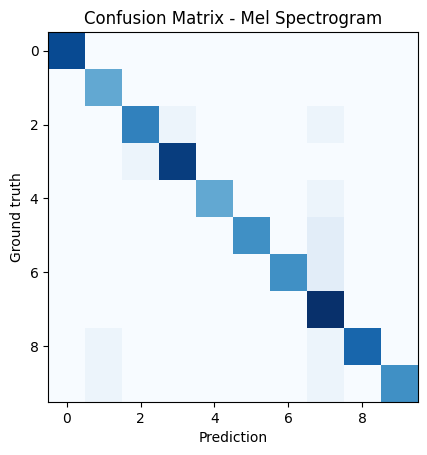

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mel, normalize=True)
print('Feature shape:', X_train[0].shape)

param_grid = {'C': [100, 500, 1000],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

print('\nBest parameters:')
print(' C: ' + str(clf.best_estimator_.C))
print(' gamma: ' + str(clf.best_estimator_.gamma))

y_pred = clf.predict(X_test)
print('\nClassification report (Mel Spectrogram):')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.title('Confusion Matrix - Mel Spectrogram')
plt.show()

**Observation:** the Mel spectrogram also achieves **92% accuracy**, matching the raw spectrogram. While the overall accuracy is identical, the per-class distribution differs: the Mel spectrogram improves precision on class 6 (from 70% to 100%) and recall on class 9 (from 71% to 86%), but slightly decreases performance on class 2 (from 100% to 90% F1). The Mel scale concentrates resolution in the lower frequencies (0–1000 Hz) where speech formants are most prominent, while grouping less informative high frequencies together. For this dataset, the advantage is modest because the signals are sampled at 8000 Hz (Nyquist = 4000 Hz), limiting the high-frequency range where the Mel scale provides the most compression.

## 3. MFCC features

Mel-Frequency Cepstral Coefficients (MFCC) are derived from the Mel spectrogram through:

1. Compute the Mel spectrogram $M(f, t)$
2. Apply logarithmic compression: $\log M(f, t)$
3. Apply the Discrete Cosine Transform (DCT) along the frequency axis:

$$c_k(t) = \sum_{m=1}^{N_{mel}} \log(M_m(t)) \cdot \cos\left[ k \left( m - \frac{1}{2} \right) \frac{\pi}{N_{mel}} \right]$$

The result is a compact, decorrelated representation of shape $(N_{mfcc}, T)$, with $N_{mfcc} = 20$ by default. MFCCs are the standard feature for speech and audio recognition.

Note: MFCC already involves a log transform internally, so no additional dB conversion is needed.

In [ ]:
def feats_mfcc(input, rate=8000, tsize=10):
    mfccs = mfcc(y=input * 1.0, sr=rate, n_fft=512)

    if mfccs.shape[1] >= tsize:
        mfccs = mfccs[:, :tsize]
    else:
        pad_width = tsize - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')

    return mfccs.ravel()

Feature shape: (200,)
Training completed in 5.790s

Best parameters:
 C: 100
 gamma: 0.005

Classification report (MFCC):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       0.93      1.00      0.97        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



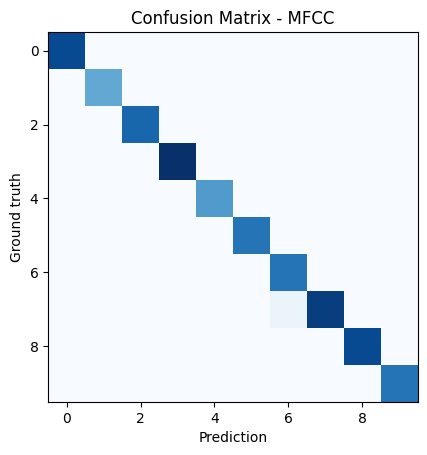

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mfcc, normalize=True)
print('Feature shape:', X_train[0].shape)

param_grid = {'C': [100, 500, 1000],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

print('\nBest parameters:')
print(' C: ' + str(clf.best_estimator_.C))
print(' gamma: ' + str(clf.best_estimator_.gamma))

y_pred = clf.predict(X_test)
print('\nClassification report (MFCC):')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.title('Confusion Matrix - MFCC')
plt.show()

**Observation:** MFCC achieves **99.3% accuracy** with only 200 features — a near-perfect result that dramatically outperforms both the spectrogram and Mel spectrogram (92% each, with 1290 and 1280 features respectively). Only 1 sample out of 150 is misclassified (one class-7 sample confused with class-6). The DCT decorrelation step removes redundancy between adjacent Mel bands, producing a compact representation where each coefficient captures an independent aspect of the spectral envelope. This also makes the SVM's job easier: fewer, more informative dimensions mean the kernel can find cleaner decision boundaries. Additionally, MFCC training is **7× faster** (5.8s vs 41.6s) due to the smaller feature vector, demonstrating that compact representations are beneficial both for accuracy and computational efficiency.

## Results comparison

We compare all three 2D feature extractors using the same `tsize=10` and hyperparameter grid.

Spectrogram: accuracy = 0.920 (C=100, gamma=0.005), feature dim = 1290
Mel Spectrogram: accuracy = 0.920 (C=100, gamma=0.005), feature dim = 1280
MFCC: accuracy = 0.993 (C=100, gamma=0.005), feature dim = 200


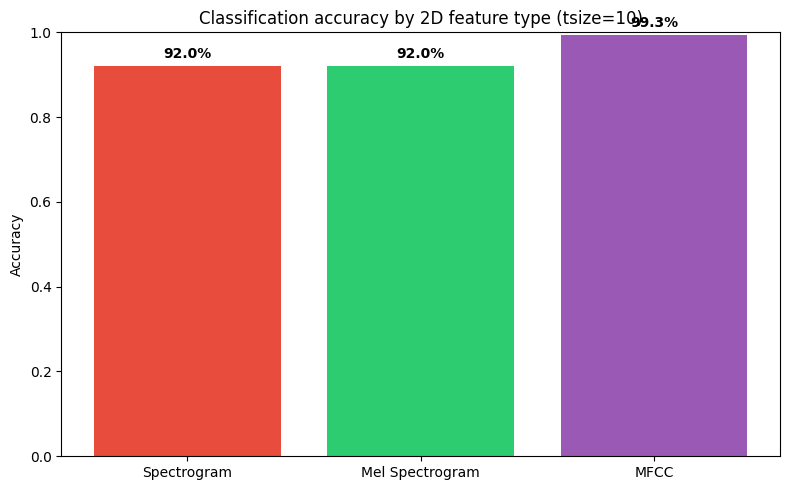

In [ ]:
configs = {
    'Spectrogram': feats_spectrogram,
    'Mel Spectrogram': feats_mel,
    'MFCC': feats_mfcc,
}

results = {}
for name, feat_fn in configs.items():
    X_train, X_test, y_train, y_test = load_data(feature_extractor=feat_fn, normalize=True)

    param_grid = {'C': [100, 500, 1000],
                  'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f'{name}: accuracy = {acc:.3f} (C={clf.best_estimator_.C}, gamma={clf.best_estimator_.gamma}), feature dim = {X_train[0].shape[0]}')

plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=['#e74c3c', '#2ecc71', '#9b59b6'])
plt.ylabel('Accuracy')
plt.title('Classification accuracy by 2D feature type (tsize=10)')
plt.ylim(0, 1)
for i, (name, acc) in enumerate(results.items()):
    plt.text(i, acc + 0.02, f'{acc:.1%}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

## Summary

| Feature | Freq. bins ($F$) | Time size ($T$) | Vector length ($F \times T$) | dB conversion | Accuracy |
|---------|:---:|:---:|:---:|:---:|:---:|
| Spectrogram | 129 | 10 | 1290 | `power_to_db` | 92.0% |
| Mel Spectrogram | 128 | 10 | 1280 | `power_to_db` | 92.0% |
| MFCC | 20 | 10 | 200 | Built-in (log) | **99.3%** |

**Key observations:**

1. **2D features vastly outperform scalar features**: the jump from 67% (E01, 7 scalar features) to 92%+ demonstrates that capturing the full time-frequency structure of the signal is essential for digit classification.

2. **dB conversion is critical**: converting power to decibel scale compresses the dynamic range, making features more suitable for the RBF kernel. Without it, a few high-energy bins would dominate the feature vector.

3. **Mel and raw spectrogram achieve identical accuracy** (92%) on this dataset. The Mel scale's advantage is more pronounced on wideband signals (e.g., 16 kHz or higher), where it can compress a wider high-frequency range. At 8 kHz, the benefit is limited.

4. **MFCC is the clear winner**: 99.3% accuracy with only 200 features (6.5× smaller than the spectrogram), thanks to the DCT decorrelation that removes inter-band redundancy. This confirms why MFCCs are the standard feature in speech recognition.

5. **Compact representations are computationally cheaper**: MFCC training takes 5.8s vs 41.6s for the spectrogram — a 7× speedup directly attributable to the smaller feature dimensionality.